**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [4]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import skvideo
skvideo.setFFmpegPath('/Users/clementlaplace/anaconda3/pkgs/ffmpeg-4.0-h01ea3c9_0/bin')
import cv2
import json
from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization, Flatten

Using TensorFlow backend.


# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [5]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [6]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The "act" function is pretty straight forward. While the agent is training and discovering the game environment, it has 2 options to play the game. The first is to act according to the policy (self.learned_act(s)), the second is to go on a random exploration and randomly select one of the 4 actions/path, in the hope to maximize Rewards with a new path undiscovered yet.

The likeliness to proceed with one of the options is defined by the value of epsilon, through the if statement "np.random.rand() <= self.epsilon". Thus epsilon is essential in defining the exploration adversity of our agent. The higher the epsilon is, the more likely the agent will be to explore path randomly.

Finally, if the agent is not training anymore and knows his environment, he will solely act according to the policy.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [7]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=1000, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [8]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=40 # set small when debugging
epochs_test=15 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.



The arrays `position` and `board` are critical as they provide for essential information for the game. The `board` gives the delimited environment in which the agent can play. While the `position` gives the position and the position evolution of our agent with respect to the actions the agent takes.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [9]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(4)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [10]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        ##### FILL IN HERE
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            
            # At each epoch, we restart to a fresh game and get the initial state
            state = env.reset()
            # This assumes that the games will end
            game_over = False

            win = 0
            lose = 0

            while not game_over:
                # The agent performs an action
                action = agent.act(state)

                # Apply an action to the environment, get the next state, the reward
                # and if the games end
                prev_state = state
                state, reward, game_over = env.act(action)

                # Update the counters
                if reward > 0:
                    win = win + reward
                if reward < 0:
                    lose = lose - reward

                # Apply the reinforcement strategy
                loss = agent.reinforce(prev_state, state,  action, reward, game_over)

            # Save as a mp4
            env.draw(prefix+str(e))

            # Update stats
            score = score + win-lose

            print("Win: {} / lose {}. Average score ({})"
                  .format(win, lose, score/(1+e)))
        print('Final score: '+str(score/epochs))

In [11]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,20,prefix='random')
HTML(display_videos('random0.mp4'))

Win: 12.0 / lose 24.0. Average score (-12.0)
Final score: -0.6
Win: 11.0 / lose 12.0. Average score (-6.5)
Final score: -0.65
Win: 10.0 / lose 17.0. Average score (-6.666666666666667)
Final score: -1.0
Win: 7.0 / lose 19.0. Average score (-8.0)
Final score: -1.6
Win: 8.5 / lose 11.0. Average score (-6.9)
Final score: -1.725
Win: 8.0 / lose 6.0. Average score (-5.416666666666667)
Final score: -1.625
Win: 9.5 / lose 16.0. Average score (-5.571428571428571)
Final score: -1.95
Win: 15.5 / lose 18.0. Average score (-5.1875)
Final score: -2.075
Win: 5.5 / lose 16.0. Average score (-5.777777777777778)
Final score: -2.6
Win: 13.5 / lose 13.0. Average score (-5.15)
Final score: -2.575
Win: 14.0 / lose 13.0. Average score (-4.590909090909091)
Final score: -2.525
Win: 13.0 / lose 21.0. Average score (-4.875)
Final score: -2.925
Win: 9.0 / lose 10.0. Average score (-4.576923076923077)
Final score: -2.975
Win: 11.5 / lose 9.0. Average score (-4.071428571428571)
Final score: -2.85
Win: 11.0 / lose 2

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [12]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory)>self.max_memory:
            del self.memory[0]

    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]

***
The pipeline we will use for training is given below:

In [13]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [45]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(s.reshape([1,s.shape[0],s.shape[1],s.shape[2]]))[0,:])

    def reinforce(self, s, n_s, a, r, game_over):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s, n_s, a, r, game_over])
        
        start_state = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            s, n_s, a, r, game_over = self.memory.random_access()
            start_state[i] = s
            target = self.model.predict(np.expand_dims(s, 0))[0]
            if game_over:
                ######## FILL IN
                target[a] = r
            else:
                ######## FILL IN
                target[a] = r + self.discount * max(self.model.predict(np.expand_dims(n_s, 0))[0])
            target_q[i, :] = target
        
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)
        l = self.model.train_on_batch(start_state, target_q)
        return l


    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model with only one simple hidden layer 
        model = Sequential()
        model.add(Flatten(input_shape=(5,5,self.n_state,)))
        model.add(Dense(32,activation ='relu')) 
        model.add(Dense(4))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()

        

In [52]:
epochs_train = 40

env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.2, epsilon = 0.4, memory_size=2000, batch_size = 32)
train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 132       
Total params: 1,764
Trainable params: 1,764
Non-trainable params: 0
_________________________________________________________________
Epoch 000/040 | Loss 0.0080 | Win/lose count 7.0/6.0 (1.0)
Epoch 001/040 | Loss 0.0108 | Win/lose count 2.5/7.0 (-4.5)
Epoch 002/040 | Loss 0.0055 | Win/lose count 5.5/5.0 (0.5)
Epoch 003/040 | Loss 0.0060 | Win/lose count 6.5/9.0 (-2.5)
Epoch 004/040 | Loss 0.0032 | Win/lose count 3.5/6.0 (-2.5)


KeyboardInterrupt: 


### This comment is for both  Q7 & Q8


In order to obtain my best set of results I played with the parameters in order to optimize them. First is the learning rate, I tried to set it to 0.4, nevertheless the results were not very conclusive. Thus I decided to opt for learning rate of 0.2.

I also modified the epsilon, e = 0.1 seemed to small. Having only a 2,5% to explore randomly the board is too risk averse. I wanted a more offensive strategy, thus I increase e to 0.4. While it increased volatility, negativelly in the first epochs, in the long run it allowed the agent to get much higher score. I only trained on 40 epochs, so the results could be higher by increasing the epochs. When trying higher epsilon, the results were too negative in the short term and took a long time before improving sufficiently.

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [58]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        model = Sequential()
        model.add(Conv2D(64,(2,2),input_shape=(5,5,2,),activation='relu'))
        model.add(Conv2D(32,(2,2),activation='relu'))
        model.add(Flatten())
        model.add(Dense(4))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()


In [55]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.2, epsilon = 0.4, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 4, 64)          576       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          8224      
_________________________________________________________________
flatten_6 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 1156      
Total params: 9,956
Trainable params: 9,956
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [38]:
env = Environment(grid_size=size, max_time=T,temperature=0.9)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 4, 4, 64)          576       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 32)          8224      
_________________________________________________________________
flatten_19 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 1156      
Total params: 9,956
Trainable params: 9,956
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_29

In [39]:
HTML(display_videos('cnn_test14.mp4'))

In [40]:
HTML(display_videos('fc_test14.mp4'))

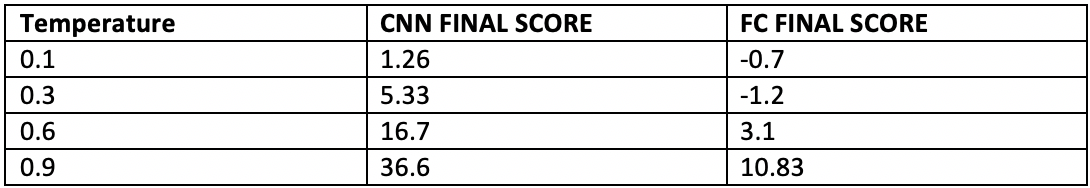

From the above evalutation, we can observe that the CNN architecture always outperforms the FC one. This seems to be mainly due to the fact that under the FC Architecture, the agent tends to stick in its place and doesn't explore the map as much as under the CNN one.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [41]:
def train_explore(agent,env,epoch,prefix=''):
    score = 0
    loss = 0
    
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature
        
        #board to play the game
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position = np.zeros((grid_size,grid_size))
        
        # coordinate of the Agent
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))
    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b
     
    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        ## In Environment exploring:
# You will have to change n_state to 3 because you will use one more layer!

        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1
        reward = reward + self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        # 3 "feature" states instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                        self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over
    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state
    

In [59]:
epochs_train = 50
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon =0.1, memory_size=2000, batch_size = 32,n_state=3) 
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 4, 4, 64)          832       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 32)          8224      
_________________________________________________________________
flatten_9 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 1156      
Total params: 10,212
Trainable params: 10,212
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected conv2d_7_input to have shape (5, 5, 3) but got array with shape (5, 5, 2)

In [64]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

ValueError: Error when checking input: expected conv2d_39_input to have shape (5, 5, 3) but got array with shape (5, 5, 2)

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***